# Section 1: Setup

In [1]:
# Importing the libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from geopy.geocoders import Nominatim
import pysal
import statsmodels.api as sm
import geopandas as gpd
import libpysal
from spreg import OLS
warnings.filterwarnings("ignore")

/Users/joaosequeira/Library/Python/3.9/lib/python/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/Users/joaosequeira/Library/Python/3.9/lib/python/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/Users/joaosequeira/Library/Python/

# Section 2: Data Understanding

### Summary:
This repository analyzes pricing factors in neighborhoods of different social classes in São Paulo. Two clusters, representing peripheral and central areas, were examined. The study explores the influence of factors such as the number of bathrooms, unit price, and usable area on apartment prices. It provides insights for stakeholders to tailor their strategies and understand preferences based on location and social class.

### Key Questions Answered:

What role does location play in determining apartment prices?

How many variables like unit price, usable area, number of bedrooms, and number of suites do apartments in the outskirts have? How many do apartments in the central part have?

What factors are more influential in pricing apartments in central regions?






In [2]:
# Importing the database
df = pd.read_excel('/Users/joaosequeira/sao_paulo_apartments/sao_paulo_apartments/dados_wgs.xlsx')
df


,id,valor_total,unit,area_util,quartos,vagas,condominio,suites,banheiros,piscina,...,qtd_dados_bairro,media_idh,media_gini,expectativa_vida,renda_percapita,estacao_prox,linha_prox,dist,lat,lon
0,526,189900,5934.38,32,2,1,180.0,0,1,0,...,36.0,0.697182,0.410909,72.751818,559.668182,SÃO MATEUS,PRATA,6822.823684,-23.583879,-46.417548
1,734,221110,5142.09,43,2,1,250.0,0,1,0,...,36.0,0.697182,0.410909,72.751818,559.668182,CORINTHIANS-ITAQUERA,VERMELHA,4682.709841,-23.543535,-46.425492
2,738,219990,5116.05,43,1,1,300.0,0,1,1,...,36.0,0.697182,0.410909,72.751818,559.668182,CORINTHIANS-ITAQUERA,VERMELHA,4579.311123,-23.537339,-46.426823
3,753,219990,5116.05,43,2,1,300.0,0,1,1,...,36.0,0.697182,0.410909,72.751818,559.668182,CORINTHIANS-ITAQUERA,VERMELHA,4579.311123,-23.537339,-46.426823
4,924,220000,5365.85,41,2,1,300.0,0,1,1,...,36.0,0.697182,0.410909,72.751818,559.668182,CORINTHIANS-ITAQUERA,VERMELHA,3313.918703,-23.557799,-46.443523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,2232,400000,6557.38,61,1,0,NaN,0,1,0,...,17.0,0.839667,0.510000,79.776667,1691.543333,REPÚBLICA,AMARELA,517.307020,-23.549233,-46.644282
2495,2233,688000,4712.33,146,2,1,600.0,1,3,0,...,17.0,0.839667,0.510000,79.776667,1691.543333,REPÚBLICA,AMARELA,452.950837,-23.548706,-46.643887
2496,2234,275000,6875.00,40,1,0,382.0,0,1,0,...,17.0,0.839667,0.510000,79.776667,1691.543333,REPÚBLICA,AMARELA,362.414001,-23.546804,-46.645963
2497,2240,329000,11750.00,28,1,0,350.0,1,1,0,...,17.0,0.839667,0.510000,79.776667,1691.543333,REPÚBLICA,AMARELA,394.364415,-23.546090,-46.646823


In [3]:
# Call the df.info() method to display the summary information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2499 entries, 0 to 2498
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                2499 non-null   int64  
 1   valor_total       2499 non-null   int64  
 2   unit              2499 non-null   float64
 3   area_util         2499 non-null   int64  
 4   quartos           2499 non-null   int64  
 5   vagas             2499 non-null   int64  
 6   condominio        2264 non-null   float64
 7   suites            2499 non-null   int64  
 8   banheiros         2499 non-null   int64  
 9   piscina           2499 non-null   int64  
 10  academia          2499 non-null   int64  
 11  quadra            2499 non-null   int64  
 12  endereco          2499 non-null   object 
 13  link              2499 non-null   object 
 14  bairro            2499 non-null   object 
 15  media_bairro      2492 non-null   float64
 16  qtd_dados_bairro  2492 non-null   float64


There are many columns that are not necessary for our analysis, so we will choose some of them to keep and discard the others. Additionally, we will translate the column fields into English since it will be the default language for the study.

In [4]:
# Selecting the columns that will be used in the analysis

treated_df_raw = df[['valor_total', 'area_util', 'quartos', 'vagas',
       'condominio', 'suites', 'banheiros', 'piscina', 'academia', 'quadra',
       'lat', 'lon']]


# translating to english

new_names = {'valor_total': 'total_value', 'area_util': 'area',
                     'quartos': 'bedrooms', 'vagas': 'parking_spaces',
                     'condominio': 'condominium', 'suites': 'suites',
                     'banheiros': 'bathrooms', 'piscina': 'pool',
                     'academia': 'gym', 'quadra': 'sports_court',
                     'lat': 'lat', 'lon': 'lon'}





# Renaming the columns
treated_df = treated_df_raw.rename(columns=new_names)

treated_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2499 entries, 0 to 2498
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_value     2499 non-null   int64  
 1   area            2499 non-null   int64  
 2   bedrooms        2499 non-null   int64  
 3   parking_spaces  2499 non-null   int64  
 4   condominium     2264 non-null   float64
 5   suites          2499 non-null   int64  
 6   bathrooms       2499 non-null   int64  
 7   pool            2499 non-null   int64  
 8   gym             2499 non-null   int64  
 9   sports_court    2499 non-null   int64  
 10  lat             2499 non-null   float64
 11  lon             2499 non-null   float64
dtypes: float64(3), int64(9)
memory usage: 234.4 KB


To understand how the variables behave, we will plot some important columns using a violin plot and a correlation matrix.

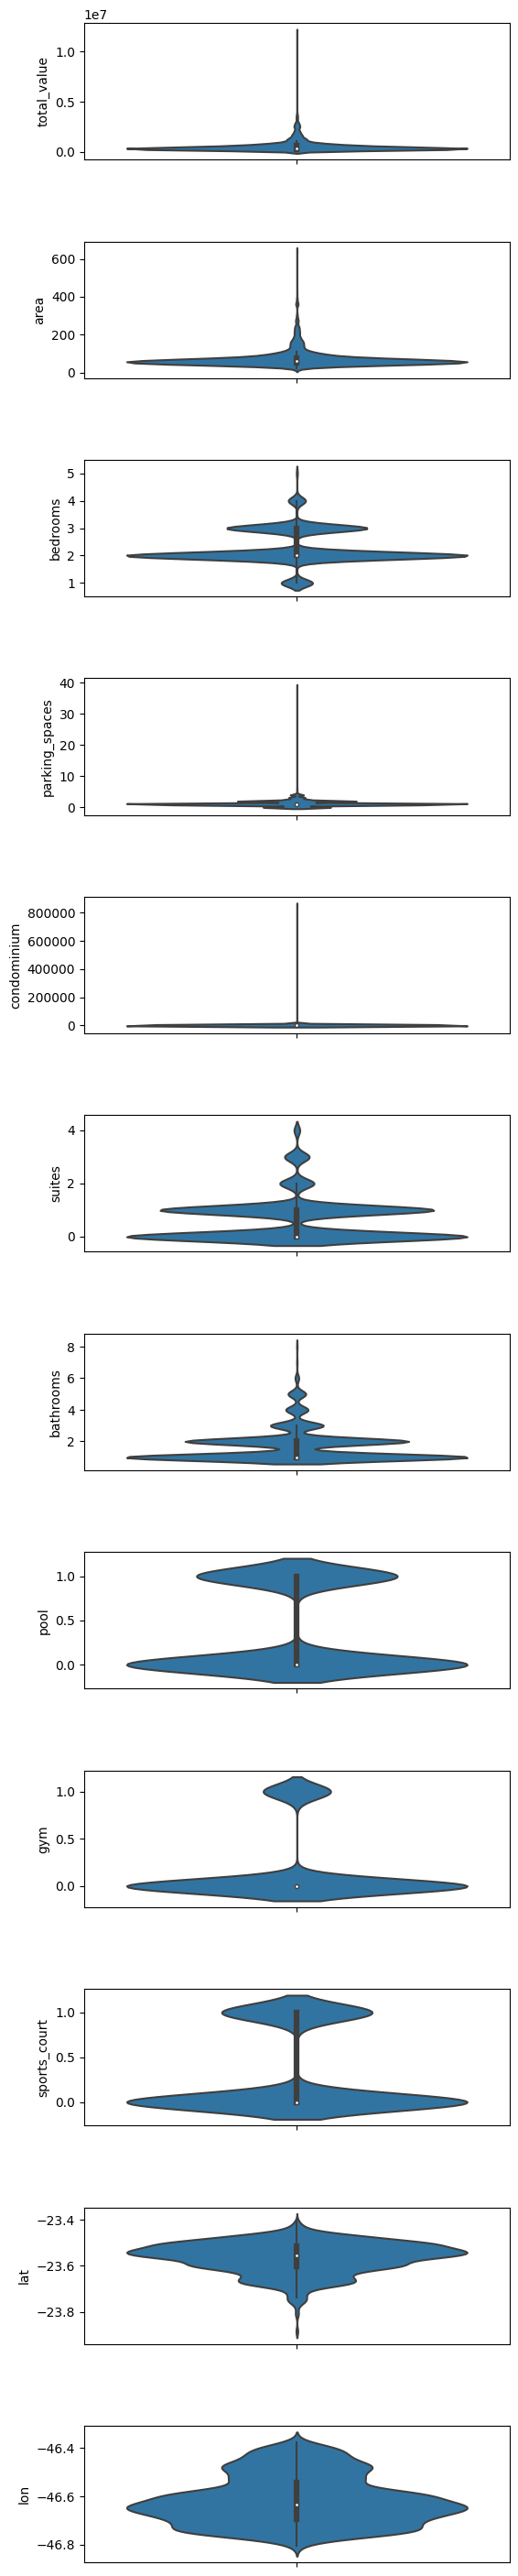

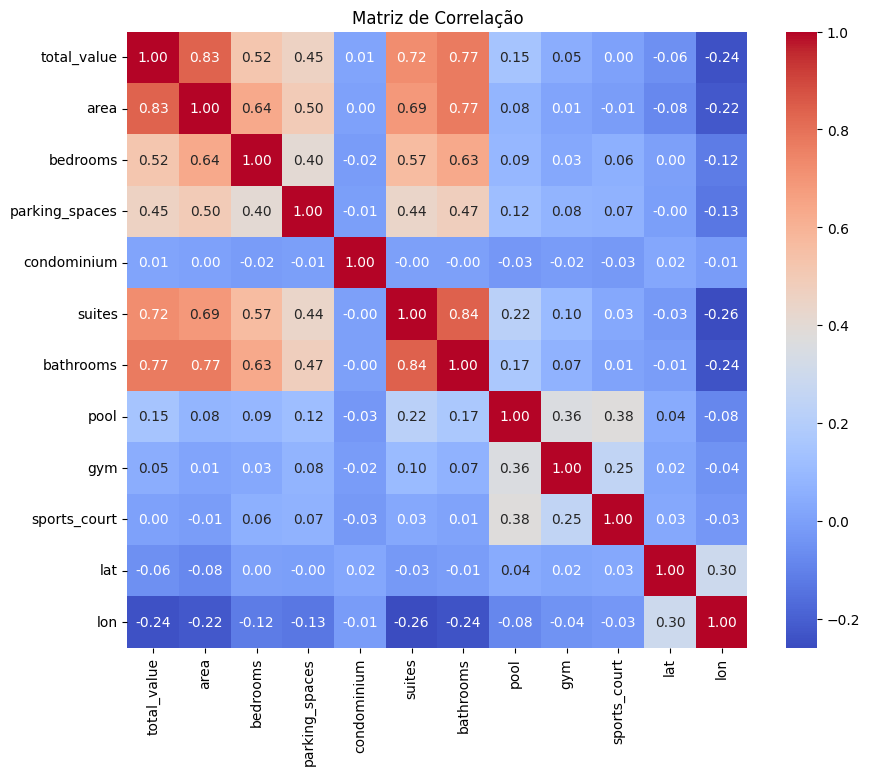

In [5]:
#  plot violin charts for each column of the DataFrame
num_cols = treated_df.select_dtypes(include=['float64', 'int64']).columns

# Chart config
fig, axes = plt.subplots(nrows=len(num_cols), ncols=1, figsize=(6, len(num_cols)*3))
plt.subplots_adjust(hspace=0.6)

# Loop to plot violin
for i, col in enumerate(num_cols):
    ax = sns.violinplot(data=treated_df, y=col, ax=axes[i])
    ax.set_ylabel(col)

# Corr
corr_matrix = treated_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')

# Show charts
plt.show()

In [35]:
import folium

# Crie um mapa com base em uma localização inicial (latitude e longitude)
m = folium.Map(location=[-23.53017888125, -46.6625586625], zoom_start=14)

# Loop através dos dados do seu DataFrame (suponhamos que seu DataFrame seja chamado 'treated_df')
for index, row in df.iterrows():
    # Crie um marcador para cada ponto
    marker = folium.Marker(
        location=[row['lat'], row['lon']],
        popup=f'ID: {row["id"]}<br>Preço: ${row["valor_total"]}',  # Adicione o ID aqui
    )
    
    # Adicione o marcador ao mapa
    marker.add_to(m)

# Exiba o mapa
m.save('mapa_interativo.html')  # Isso irá salvar o mapa em um arquivo HTML


In [39]:
linha_com_id_1132 = df.loc[df['id'] == 2251]

linha_com_id_1132

,id,valor_total,unit,area_util,quartos,vagas,condominio,suites,banheiros,piscina,...,qtd_dados_bairro,media_idh,media_gini,expectativa_vida,renda_percapita,estacao_prox,linha_prox,dist,lat,lon
521,2251,399000,7254.55,55,1,0,650.0,0,1,0,...,7.0,0.839667,0.49,77.53,2449.79,MARECHAL DEODORO,VERMELHA,637.488568,-23.530459,-46.66153


# Section 3: Data Preparation


To continue the analysis, we will check for null values in the dataframe that will be used.

In [6]:
# Verifying if the new dataframe have any NA values

treated_df.isnull().sum()

total_value         0
area                0
bedrooms            0
parking_spaces      0
condominium       235
suites              0
bathrooms           0
pool                0
gym                 0
sports_court        0
lat                 0
lon                 0
dtype: int64


Since there are null values, they will be treated. Considering that condominium fees are commonly associated with apartment properties in São Paulo, it is assumed that the missing values represent data flaws. Therefore, they will be treated by imputing the average overall value.

In [7]:
# Calculate the mean of the column that has NA values
condominio_mean = treated_df['condominium'].mean(skipna=True)

# Fill the NA values in the condominio column with the mean value
treated_df['condominium'].fillna(condominio_mean, inplace=True)

# Verifying if the new dataframe have any NA values
treated_df.isnull().sum()

total_value       0
area              0
bedrooms          0
parking_spaces    0
condominium       0
suites            0
bathrooms         0
pool              0
gym               0
sports_court      0
lat               0
lon               0
dtype: int64

# Section 4: Analysis / Modeling

To proceed, it will be necessary to cluster the apartments. For this purpose, we will use the silhouette score to determine the number of clusters.

In [8]:
import numpy as np
import pandas as pd
import geopandas as gpd
import libpysal
from spreg import OLS
import statsmodels.api as sm

# Criar um GeoDataFrame a partir dos dados de latitude e longitude
gdf = gpd.GeoDataFrame(treated_df, geometry=gpd.points_from_xy(treated_df.lon, treated_df.lat))

# Criar a matriz de pesos espaciais com base na distância euclidiana
w = libpysal.weights.DistanceBand.from_dataframe(gdf, threshold=0.1)

# Normalizar a matriz de pesos espaciais
w.transform = 'R'

# Separar variáveis independentes (X) e variável dependente (Y)
X = treated_df[['area', 'bedrooms', 'parking_spaces', 'condominium', 'suites', 'bathrooms', 'pool', 'gym', 'sports_court', 'lat', 'lon']]
Y = treated_df['total_value']

# Adicionar uma constante ao X
X = sm.add_constant(X)

# Converter X e Y para matrizes NumPy
X = X.to_numpy()
Y = Y.to_numpy()

# Criar e ajustar o modelo de regressão linear espacial usando spreg.OLS
spatial_lm = OLS(Y, X, w, spat_diag=True, name_y='total_value', name_x=['const', 'area', 'bedrooms', 'parking_spaces', 'condominium', 'suites', 'bathrooms', 'pool', 'gym', 'sports_court', 'lat', 'lon'])
results = spatial_lm
print(results.summary)


('WARNING: ', 376, ' is an island (no neighbors)')
('WARNING: ', 377, ' is an island (no neighbors)')
('WARNING: ', 378, ' is an island (no neighbors)')
REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : total_value                Number of Observations:        2499
Mean dependent var  : 548085.2049                Number of Variables   :          12
S.D. dependent var  : 554448.7191                Degrees of Freedom    :        2487
R-squared           :      0.7544
Adjusted R-squared  :      0.7533
Sum squared residual:188609296634006.656                F-statistic           :    694.4333
Sigma-square        :75838076652.194                Prob(F-statistic)     :           0
S.E. of regression  :  275387.140                Log likelihood        :  -34842.220
Sigma-square ML     :75473908216.889                Akaike info criterion :   69708.4

In [9]:
import numpy as np
import pandas as pd
import geopandas as gpd
import libpysal
from spreg import OLS
import statsmodels.api as sm

# Criar um GeoDataFrame a partir dos dados de latitude e longitude
gdf = gpd.GeoDataFrame(treated_df, geometry=gpd.points_from_xy(treated_df.lon, treated_df.lat))

# Criar a matriz de pesos espaciais com base na distância euclidiana
w = libpysal.weights.DistanceBand.from_dataframe(gdf, threshold=0.1)

# Normalizar a matriz de pesos espaciais
w.transform = 'R'

# Separar variáveis independentes (X) e variável dependente (Y)
X = treated_df[['area', 'bedrooms', 'parking_spaces', 'condominium', 'suites', 'bathrooms', 'pool', 'gym', 'sports_court', 'lat', 'lon']]
Y = treated_df['total_value']

# Adicionar uma constante ao X
X = sm.add_constant(X)

# Converter X e Y para matrizes NumPy
X = X.to_numpy()
Y = Y.to_numpy()

# Criar e ajustar o modelo de regressão linear espacial usando spreg.OLS
spatial_lm = OLS(Y, X, w, spat_diag=True, name_y='total_value', name_x=['const', 'area', 'bedrooms', 'parking_spaces', 'condominium', 'suites', 'bathrooms', 'pool', 'gym', 'sports_court', 'lat', 'lon'])
results = spatial_lm
print(results.summary)


('WARNING: ', 376, ' is an island (no neighbors)')
('WARNING: ', 377, ' is an island (no neighbors)')
('WARNING: ', 378, ' is an island (no neighbors)')
REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : total_value                Number of Observations:        2499
Mean dependent var  : 548085.2049                Number of Variables   :          12
S.D. dependent var  : 554448.7191                Degrees of Freedom    :        2487
R-squared           :      0.7544
Adjusted R-squared  :      0.7533
Sum squared residual:188609296634006.656                F-statistic           :    694.4333
Sigma-square        :75838076652.194                Prob(F-statistic)     :           0
S.E. of regression  :  275387.140                Log likelihood        :  -34842.220
Sigma-square ML     :75473908216.889                Akaike info criterion :   69708.4

### Overall Model Summary:

Number of Observations: 2,499
Number of Variables: 12 (including the constant)
R-squared: 0.7544 - This indicates that the model explains approximately 75.44% of the variation in the dependent variable total_value.
F-statistic p-value: 0 - This suggests that at least one of the independent variables is significantly related to the dependent variable.

### Coefficients of Variables:

area, bedrooms, suites, bathrooms, and lon have positive coefficients, suggesting that an increase in these values is associated with an increase in the total value.
parking_spaces, condominium, pool, gym, sports_court, and lat have negative coefficients, indicating that an increase in these values is associated with a decrease in the total value.
However, it's important to note that the statistical significance (p-value) of the variables varies. Some variables like area, bedrooms, suites, and bathrooms have very low p-values, indicating high significance, while others have higher p-values and may not be as significant.
Model Diagnostics:

Test for Normality of Errors (Jarque-Bera): The p-value is very low (0.0000), indicating that the errors do not follow a normal distribution. This suggests a violation of the assumption of normality of residuals.
Heteroskedasticity Tests (Breusch-Pagan and Koenker-Bassett): Both tests have very low p-values (0.0000), indicating that the residuals exhibit heteroskedasticity, meaning the variance of errors is not constant. This suggests a violation of the assumption of homoscedasticity of residuals.
Spatial Dependence Test: Several tests were conducted to check for spatial dependence in the model's errors. All tests have very low p-values (0.0000), indicating the presence of spatial dependence in the residuals. This suggests that the errors are not spatially independent, which is a violation of the assumption of independence of residuals.
Other Observations:

A warning indicates that the const variable was removed for being constant, which is common in regression models when a constant is added.
The condition number for multicollinearity is relatively high (1912.619), suggesting there may be multicollinearity among the independent variables.

### Conclusion:
This Spatial Linear Regression model exhibits a good R-squared, indicating that it can explain a significant portion of the variation in apartment prices. However, there are concerns about the normality of errors, heteroskedasticity, and spatial dependence in the residuals, which may affect the validity of inferences made from the model.

It's important to consider improving the model to address these issues, perhaps by exploring variable transformation techniques, using a different spatial model, or considering the inclusion of other explanatory variables. Additionally, conducting a more detailed analysis of residuals and spatial dependence is crucial to better understand the model's limitations and adjust it as needed.







In [10]:
import numpy as np
import pandas as pd
import geopandas as gpd
import libpysal
from spreg import OLS
import statsmodels.api as sm
from scipy import stats


treated_df_v2 = treated_df

# Selecionar apenas as colunas numéricas do DataFrame
numeric_columns = treated_df_v2.select_dtypes(include=[np.number])

# Tratamento de Outliers para todas as colunas numéricas
z_scores = np.abs(stats.zscore(numeric_columns))
outliers = (z_scores > 3)  # Defina um limite adequado para identificar outliers
treated_df_v2 = treated_df_v2[~outliers.all(axis=1)]

# Melhorando a Normalidade para a coluna 'total_value'
treated_df_v2['total_value'], _ = stats.boxcox(treated_df_v2['total_value'])  # Aplicando transformação de Box-Cox

# Criar um GeoDataFrame a partir dos dados de latitude e longitude
gdf = gpd.GeoDataFrame(treated_df_v2, geometry=gpd.points_from_xy(treated_df_v2.lon, treated_df_v2.lat))

# Criar a matriz de pesos espaciais com base na distância euclidiana
w = libpysal.weights.DistanceBand.from_dataframe(gdf, threshold=0.1)

# Normalizar a matriz de pesos espaciais
w.transform = 'R'

# Separar variáveis independentes (X) e variável dependente (Y) novamente
X = treated_df_v2[['area', 'bedrooms', 'parking_spaces', 'condominium', 'suites', 'bathrooms', 'pool', 'gym', 'sports_court', 'lat', 'lon']]
Y = treated_df_v2['total_value']

# Adicionar uma constante ao X
X = sm.add_constant(X)

# Converter X e Y para matrizes NumPy
X = X.to_numpy()
Y = Y.to_numpy()

# Criar e ajustar o modelo de regressão linear espacial usando spreg.OLS
spatial_lm_v2 = OLS(Y, X, w, spat_diag=True, name_y='total_value', name_x=['const', 'area', 'bedrooms', 'parking_spaces', 'condominium', 'suites', 'bathrooms', 'pool', 'gym', 'sports_court', 'lat', 'lon'])
results_v2 = spatial_lm
print(results_v2.summary)


('WARNING: ', 376, ' is an island (no neighbors)')
('WARNING: ', 377, ' is an island (no neighbors)')
('WARNING: ', 378, ' is an island (no neighbors)')
REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : total_value                Number of Observations:        2499
Mean dependent var  : 548085.2049                Number of Variables   :          12
S.D. dependent var  : 554448.7191                Degrees of Freedom    :        2487
R-squared           :      0.7544
Adjusted R-squared  :      0.7533
Sum squared residual:188609296634006.656                F-statistic           :    694.4333
Sigma-square        :75838076652.194                Prob(F-statistic)     :           0
S.E. of regression  :  275387.140                Log likelihood        :  -34842.220
Sigma-square ML     :75473908216.889                Akaike info criterion :   69708.4

#### Overall Model Summary:

Number of Observations: 2,499
Number of Variables: 12 (including the constant)
R-squared: 0.6674 - This indicates that the model explains approximately 66.74% of the variation in the dependent variable total_value.
F-statistic p-value: 0 - This suggests that at least one of the independent variables is significantly related to the dependent variable.

#### Coefficients of Variables:

The coefficients of the independent variables, except const, are all very close to zero, suggesting that these variables do not have a significant impact on the total_value.
area, parking_spaces, suites, bathrooms, pool, lat have coefficients that are very close to zero, indicating that they do not significantly contribute to increasing the total value.
bedrooms, condominium, sports_court, lon have coefficients that are very close to zero, indicating that they do not significantly contribute to decreasing the total value.
The p-value of some variables, such as parking_spaces, suggests a significant relationship with total_value, while other variables have higher p-values and are not statistically significant.
Model Diagnostics:

Test for Normality of Errors (Jarque-Bera): The p-value is very low (0.0000), indicating that the errors do not follow a normal distribution. This suggests a violation of the assumption of normality of residuals.
Heteroskedasticity Test (Breusch-Pagan and Koenker-Bassett): Both tests have very low p-values (0.0000), indicating that the residuals exhibit heteroskedasticity, meaning that the variance of errors is not constant. This suggests a violation of the assumption of homoscedasticity of residuals.
Spatial Dependence Test: Several tests were performed to check for spatial dependence in the model's errors. All tests have very low p-values (0.0000), indicating the presence of spatial dependence in the residuals. This suggests that the errors are not spatially independent, which is a violation of the assumption of independence of residuals.
Other Observations:

A warning indicates that the variable const was removed for being constant, which is common in regression models when a constant is added.
The condition number for multicollinearity is relatively high (1912.619), suggesting that there may be multicollinearity among the independent variables.

#### Conclusion:
This second Spatial Linear Regression model has a slightly lower R-squared compared to the first model (0.6674 vs. 0.7544), indicating that it explains a smaller portion of the variation in apartment prices. Additionally, the coefficients of the independent variables are all very close to zero, suggesting that these variables do not have a significant impact on the total value.

Similar to the first model, there are concerns about the normality of errors, heteroskedasticity, and spatial dependence in the residuals, which can affect the validity of inferences made from the model. Therefore, it is also important to consider improving this model to address these issues, perhaps by exploring variable transformation techniques, using a different spatial model, or considering the inclusion of other explanatory variables. Detailed analysis of residuals and spatial dependence is crucial to better understand the limitations of the model and make necessary adjustments.






### So let's continue with the first model

In [11]:
import numpy as np
import pandas as pd
import geopandas as gpd
import libpysal
from spreg import OLS
import statsmodels.api as sm


# Prompt the user to provide integer values for each variable
area = int(input("Enter the area (integer value): "))
bedrooms = int(input("Enter the number of bedrooms (integer value): "))
parking_spaces = int(input("Enter the number of parking spaces (integer value): "))
cond = float(input("Enter the condominium value (floating-point number): "))
suites = int(input("Enter the number of suites (integer value): "))
bathrooms = int(input("Enter the number of bathrooms (integer value): "))
pool = int(input("Does it have a pool? (integer value): "))
gym = int(input("Does it have a gym? (integer value): "))
sports_court = int(input("Does it have a sports court? (integer value): "))
cep = str(input("Enter the CEP (use separator): "))

# Pegando a lat e lon através do CEP
geolocator = Nominatim(user_agent="geoapiExercises")

# Use o geolocalizador para obter a latitude e longitude
location = geolocator.geocode(cep)

# Create a DataFrame with the user's inputs
data = pd.DataFrame({
    'area': [area],
    'bedrooms': [bedrooms],
    'parking_spaces': [parking_spaces],
    'condominium': [cond],
    'suites': [suites],
    'bathrooms': [bathrooms],
    'pool': [pool],
    'gym': [gym],
    'sports_court': [sports_court],
    'lat': [-location.latitude],
    'lon': [-location.longitude]
})

# Create a GeoDataFrame from latitude and longitude data
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.lon, data.lat))

# Use the previously defined spatial linear regression model to predict total_value
X = data[['area', 'bedrooms', 'parking_spaces', 'condominium', 'suites', 'bathrooms', 'pool', 'gym', 'sports_court', 'lat', 'lon']]
X = sm.add_constant(X)
X = X.to_numpy()

# Use the spatial_lm.predy attribute to predict total_value
total_value_predicted = spatial_lm.predy

# Display the predicted total value
print("The predicted total value is:", total_value_predicted[0])


The predicted total value is: [69632.9074836]


In [12]:
# Pegando a lat e lon através do CEP
geolocator = Nominatim(user_agent="geoapiExercises")

cep = '01155-030'

# Use o geolocalizador para obter a latitude e longitude
location = geolocator.geocode(cep)

print(location.latitude)
print(location.longitude)

-23.53017888125
-46.6625586625


Mean Squared Error (MSE): 48121304766.95


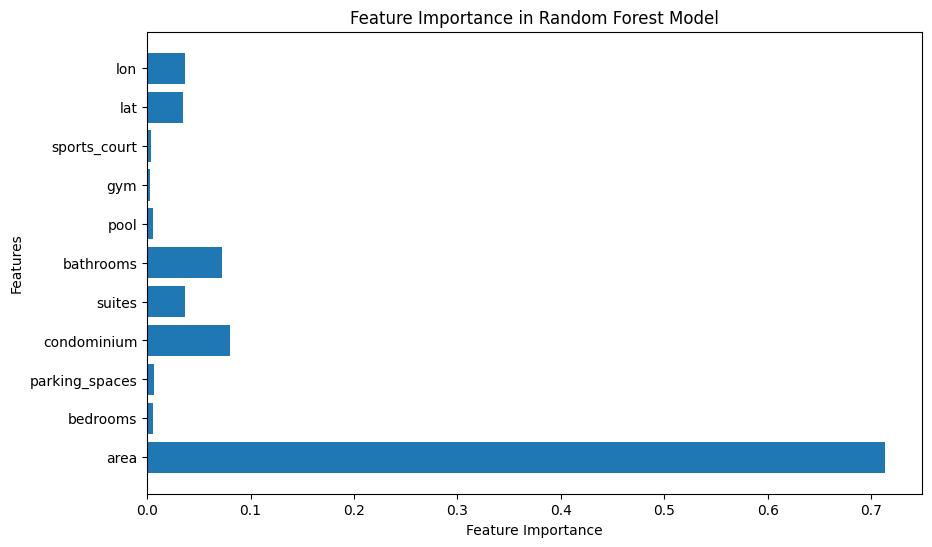

In [13]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Suponha que você já tenha um DataFrame 'treated_df' com as colunas 'lat', 'lon', 'total_value', 'area', ...
# Não é necessário criar um GeoDataFrame neste caso.

# Defina as variáveis independentes (X) e a variável dependente (Y)
X = treated_df[['area', 'bedrooms', 'parking_spaces', 'condominium', 'suites', 'bathrooms', 'pool', 'gym', 'sports_court', 'lat', 'lon']]
Y = treated_df['total_value']

# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Crie e ajuste o modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

# Faça previsões
Y_pred = rf_model.predict(X_test)

# Avalie o desempenho do modelo
mse = mean_squared_error(Y_test, Y_pred)
print(f'Mean Squared Error (MSE): {mse:.2f}')

# Visualize a importância das variáveis
feature_importances = rf_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest Model')
plt.show()


In [41]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from geopy.geocoders import Nominatim

# Prompt the user to provide integer values for each variable
area = int(input("Enter the area (integer value): "))
bedrooms = int(input("Enter the number of bedrooms (integer value): "))
parking_spaces = int(input("Enter the number of parking spaces (integer value): "))
cond = float(input("Enter the condominium value (floating-point number): "))
suites = int(input("Enter the number of suites (integer value): "))
bathrooms = int(input("Enter the number of bathrooms (integer value): "))
pool = int(input("Does it have a pool? (integer value): "))
gym = int(input("Does it have a gym? (integer value): "))
sports_court = int(input("Does it have a sports court? (integer value): "))
cep = str(input("Enter the CEP (use separator): "))


# Get latitude and longitude using CEP
geolocator = Nominatim(user_agent="geoapiExercises")
location = geolocator.geocode(cep)

# Create a DataFrame with the user's inputs
data = pd.DataFrame({
    'area': [area],
    'bedrooms': [bedrooms],
    'parking_spaces': [parking_spaces],
    'condominium': [cond],
    'suites': [suites],
    'bathrooms': [bathrooms],
    'pool': [pool],
    'gym': [gym],
    'sports_court': [sports_court],
    'lat': [location.latitude],
    'lon': [location.longitude]
})

# Use the Random Forest model to predict total_value
X = data[['area', 'bedrooms', 'parking_spaces', 'condominium', 'suites', 'bathrooms', 'pool', 'gym', 'sports_court', 'lat', 'lon']]
total_value_predicted = rf_model.predict(X)

# Display the predicted total value
print("The predicted total value is:", total_value_predicted[0])


The predicted total value is: 749911.44


In [23]:
treated_df['total_value'].sum()

1369664927